In [17]:
import json
import matplotlib.pyplot as plt
import networkx as nx
from geopy.distance import geodesic
import re

# Load the tour data
with open("safaris_30_items_enhanced.json", "r", encoding="utf-8") as f:
    tours = json.load(f)

In [18]:

# Define a dictionary for district coordinates
district_coordinates = {
    "gampaha": (7.15, 79.85),
    "ratnapura": (6.7, 80.4),
    "colombo": (6.9271, 79.8612),
    "kandy": (7.2906, 80.6337),
    "galle": (6.0535, 80.2210),
    "jaffna": (9.6647, 80.0177),
    "anuradhapura": (8.3114, 80.4037),
    "polonnaruwa": (7.9381, 81.0069),
    "trincomalee": (8.5875, 81.2114),
    "batticaloa": (7.7289, 81.7018),
    "kurunegala": (7.4878, 80.3653),
    "nuwara eliya": (6.9497, 80.7891),
    "badulla": (6.9933, 81.0550),
    "monaragala": (6.8732, 81.3592),
    "hambantota": (6.1242, 81.1219)
}


In [19]:

def parse_coordinate(coord_str):
    """
    Converts coordinate strings like '7.15° N' or '79.85° E' to float values: 7.15 or 79.85.
    Assumes N and E are positive, S and W are negative.
    """
    if not isinstance(coord_str, str):
        return float(coord_str)  # already numeric

    coord_str = coord_str.strip().replace("°", "")
    if "N" in coord_str or "E" in coord_str:
        return float(coord_str.replace("N", "").replace("E", "").strip())
    elif "S" in coord_str or "W" in coord_str:
        return -float(coord_str.replace("S", "").replace("W", "").strip())
    else:
        return float(coord_str.strip())  # fallback

def extract_district_from_query(query, districts):
    """
    Extracts a district name from a user query string.
    """
    query_lower = query.lower()
    for district in districts:
        if re.search(r'\b' + re.escape(district) + r'\b', query_lower):
            return district
    return None

def find_safaris_near_location(user_query, data, district_coords):
    """
    Finds and sorts safari tours near a specified district based on a user query.
    """
    extracted_district = extract_district_from_query(user_query, district_coords.keys())
    
    if extracted_district:
        user_coords = district_coords.get(extracted_district)
        print(f"✅ Found district '{extracted_district}' in your query. Searching for safaris nearby.")
    else:
        print("⚠️ Warning: Could not find a recognizable district in your query. Using default coordinates for Gampaha (7.15, 79.85).")
        user_coords = (7.15, 79.85)

    results = []
    
    for item in data:
        features = item.get("extracted_features", {})
        if "latitude" not in features or "longitude" not in features:
            continue  # skip if missing coords

        try:
            lat = parse_coordinate(features["latitude"])
            lon = parse_coordinate(features["longitude"])
        except (ValueError, KeyError):
            continue  # skip on bad format or missing keys

        safari_coords = (lat, lon)
        distance = geodesic(user_coords, safari_coords).km

        if features.get("district", "").lower() == extracted_district or distance <= 50:
            item["distance_km"] = round(distance, 2)
            results.append(item)

    # Sort results by rating (descending) and then distance (ascending)
    sorted_results = sorted(results, key=lambda x: (-float(x.get("rating", 0)), x.get("distance_km", float('inf'))))
    
    return sorted_results


✅ Found district 'polonnaruwa' in your query. Searching for safaris nearby.


C:\Users\thara\AppData\Local\Temp\ipykernel_20324\609828674.py:32: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


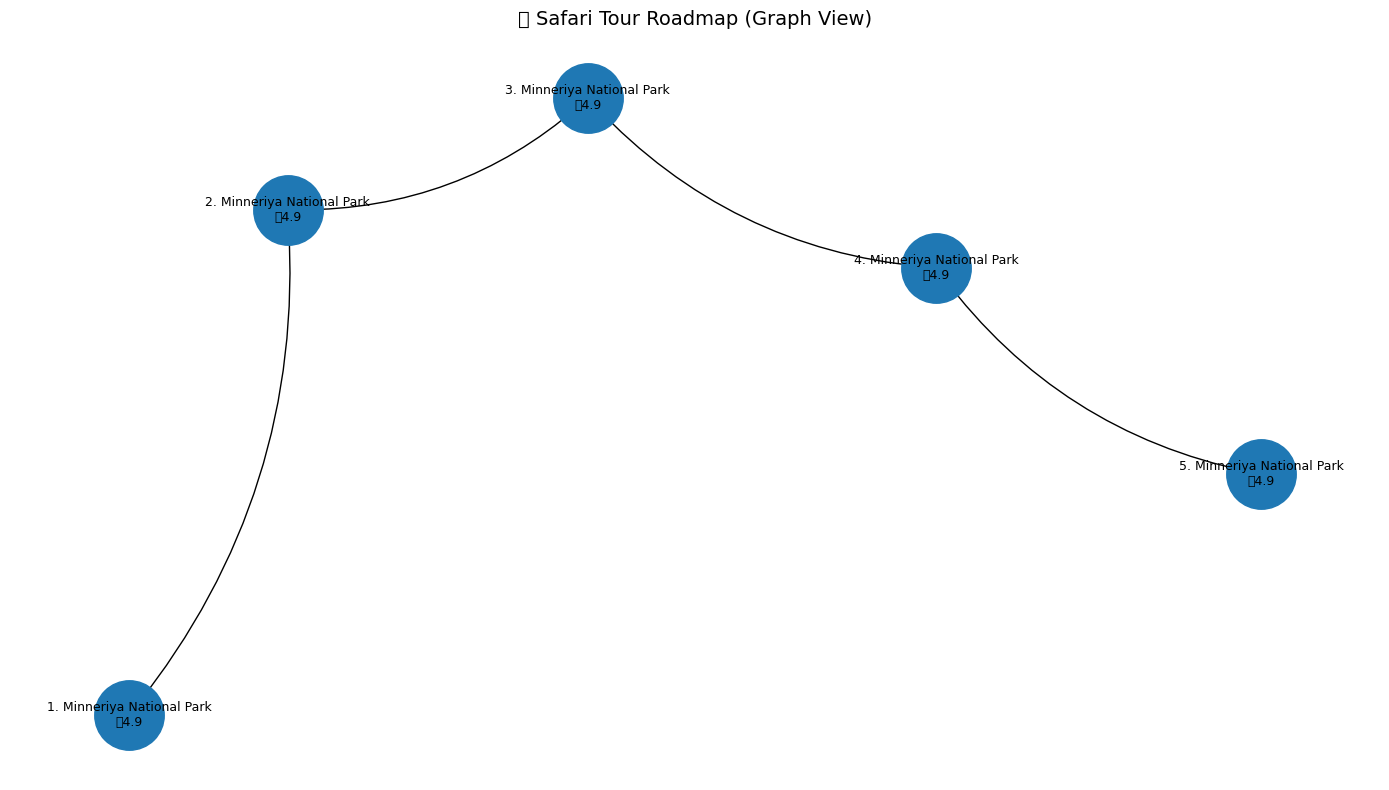

In [20]:

def visualize_roadmap_graph(roadmap):
    """
    Visualizes the top safari tours as a directed graph.
    """
    if not roadmap:
        print("🚫 No roadmap to display.")
        return

    G = nx.DiGraph()

    labels = {}
    for idx, item in enumerate(roadmap):
        title = item["title"]
        # Use the first park name found, or 'Unknown' if none
        park = item["extracted_features"]["park_names"][0] if item["extracted_features"].get("park_names") else "Unknown"
        label = f"{idx+1}. {park}\n⭐{item.get('rating', '?')}"
        G.add_node(title)
        labels[title] = label

    # Add edges to form a path connecting the top safaris
    for i in range(len(roadmap) - 1):
        G.add_edge(roadmap[i]["title"], roadmap[i+1]["title"])

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(14, 8))
    nx.draw_networkx_nodes(G, pos, node_size=2500)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, connectionstyle='arc3,rad=0.2')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.title("🗺️ Safari Tour Roadmap (Graph View)", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- Main execution part ---
user_query = input("Please enter your query (e.g., 'near Gampaha', 'I want to visit Ratnapura'): ")
matching_tours = find_safaris_near_location(user_query, tours, district_coordinates)

# Display the top 5 matching tours
roadmap = matching_tours[:5]
visualize_roadmap_graph(roadmap)

In [21]:
import json
import matplotlib.pyplot as plt
import networkx as nx
from geopy.distance import geodesic
import re
from IPython.display import Image, display

# Load the tour data (This should be in a preceding cell)
# with open("safaris_30_items_enhanced.json", "r", encoding="utf-8") as f:
#     tours = json.load(f)

# Define a dictionary for district coordinates (This should be in a preceding cell)
# district_coordinates = { ... }

# Define helper functions (These should be in preceding cells)
# def parse_coordinate(coord_str): ...
# def extract_district_from_query(query, districts): ...
# def find_safaris_near_location(user_query, data, district_coords): ...
# def visualize_roadmap_graph(roadmap): ...

def display_safari_details_with_images(roadmap, user_query):
    """
    Displays the details of the suggested safari tours, including the image.
    """
    if not roadmap:
        print("🚫 No safari tours found for your query.")
        return

    # Extract the district from the user query for a more personalized message
    extracted_district = extract_district_from_query(user_query, district_coordinates.keys())
    display_location = extracted_district.capitalize() if extracted_district else "your specified location"
    
    print(f"Suggested Safari Tours near {display_location}:\n")

    for idx, tour in enumerate(roadmap):
        title = tour.get("title", "N/A")
        rating = tour.get("rating", "N/A")
        duration = tour.get("travel_duration", "N/A")
        price = tour.get("starting_price", "N/A")
        image_link = tour.get("image_links", [None])[0]

        print(f"{idx+1}. {title}")
        print(f"   ⭐ Rating: {rating}")
        print(f"   ⏱️ Duration: {duration}")
        print(f"   💰 Starting Price: {price}")
        
        if image_link:
            try:
                # Display the image using IPython.display.Image
                display(Image(url=image_link, width=400, height=300))
            except Exception as e:
                print(f"   ⚠️ Could not display image from link: {image_link}")
                print(f"   Error: {e}")
        
        print("-" * 50)

# --- Main execution part ---
# These lines should be in a preceding cell to get the user query and roadmap
# user_query = input("Please enter your query (e.g., 'near Gampaha', 'I want to visit Ratnapura'): ")
# matching_tours = find_safaris_near_location(user_query, tours, district_coordinates)
# roadmap = matching_tours[:5]

# Assuming `roadmap` and `user_query` are already defined from a previous cell
if 'roadmap' in locals() and 'user_query' in locals():
    display_safari_details_with_images(roadmap, user_query)
else:
    print("Please run the preceding cells to generate the roadmap data.")

Suggested Safari Tours near Polonnaruwa:

1. Private Jeep Safari at Minneriya National Park to Visit Elephants
   ⭐ Rating: 4.9
   ⏱️ Duration: 3–4 hours
   💰 Starting Price: $35


--------------------------------------------------
2. Private Jeep Safari at Minneriya National Park - Half Day Tour
   ⭐ Rating: 4.9
   ⏱️ Duration: 3–4 hours
   💰 Starting Price: $32


--------------------------------------------------
3. Minneriya National Park halfday Safari
   ⭐ Rating: 4.9
   ⏱️ Duration: 3–4 hours
   💰 Starting Price: $50


--------------------------------------------------
4. Minneriya National Park Elephant Jeep Safari Private Tour
   ⭐ Rating: 4.9
   ⏱️ Duration: 3–5 hours
   💰 Starting Price: $52


--------------------------------------------------
5. Safari Tour at Minneriya National Park
   ⭐ Rating: 4.9
   ⏱️ Duration: 5 hours
   💰 Starting Price: $76


--------------------------------------------------
